## PINN#2 Basic Working 

### Basic Architecture

In [11]:
import torch
import torch.nn as nn

class LinearNN(nn.Module):
    def __init__(self, num_inputs=1, num_layers=1, num_neurons=5, act=nn.Tanh()):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers
        
        layers = []
        
        # Input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))
        
        # Hidden layers with linear layer and activation function
        for _ in range(num_layers):
            layers.append(nn.Linear(num_neurons, num_neurons))
            layers.append(act)
        
        # Output layer
        layers.append(nn.Linear(num_neurons, 1))
        
        # Build network 
        self.network = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()

### Build Loss Function


In [22]:
model = LinearNN()
x = torch.Tensor
params = dict[str, torch.nn.Parameter]

def f(x: torch.Tensor, params: dict[str, torch.nn.Parameter]) -> torch.Tensor:
    return model(x).mean()  # Taking the mean to ensure scalar output

# Compute the first derivative of f with respect to x
def dfdx(x, params) -> torch.Tensor:
    # Compute gradients
    gradients = torch.autograd.grad(f(x, params), x, create_graph=True)[0]
    return gradients

# Compute the second derivative of f with respect to x
def d2fdx2(x, params) -> torch.Tensor:
    # Compute gradients of gradients
    gradients = torch.autograd.grad(dfdx(x, params), x, create_graph=True)[0]
    return gradients

#### Using the functions defined above, the MSE loss is easily computed as a sum of the DE contribution at each colocation point and the boundary contribution. Notice that, given the functional nature of the forward pass and derivatives, the loss function must also take the model params as input argument:

In [28]:
R = 1.0 # rate of maximum population growth parameterizing the equation
X_BOUNDRY = 0.0 # boundary condition coordinate
F_BOUNDRY = 0.5 # boundary condition value

def loss_fn(params:torch.Tensor, x:torch.Tensor):
    
    # interior loss
    f_value = f(x, params)
    interior = dfdx(x,params) - R * f_value * ( 1- f_value)
    
    #boundry loss
    x0 = X_BOUNDRY
    f0 = F_BOUNDRY
    x_boundry = torch.Tensor([x0])
    f_boundry = torch.Tensor([f0])
    boundry = f(x_boundry, params) -  f_boundry
    
    loss = nn.MSELoss()
    loss_value =  loss(interior, torch.zeros_like(interior)) + loss(
        boundary, torch.zeros_like(boundary)
    )

    return loss_value

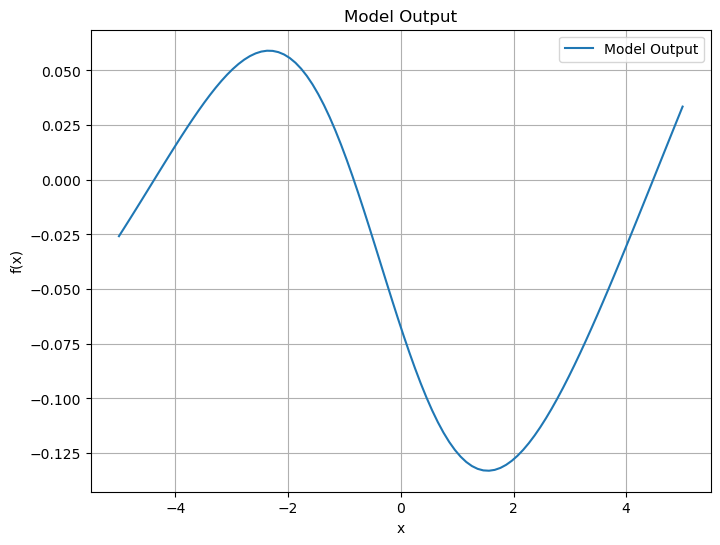

RuntimeError: One of the differentiated Tensors does not require grad

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Function to generate input data
def generate_input_data(domain=(-5.0, 5.0), num_points=100):
    x_values = np.linspace(domain[0], domain[1], num_points)
    return torch.Tensor(x_values).unsqueeze(1)

# Generate input data
x_data = generate_input_data()

# Compute model output
with torch.no_grad():
    y_pred = model(x_data).numpy()

# Plot model output
plt.figure(figsize=(8, 6))
plt.plot(x_data.numpy(), y_pred, label='Model Output')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Model Output')
plt.legend()
plt.grid(True)
plt.show()

# Training loop
losses = []
for i in range(num_iter):
    # Sample points in the domain randomly for each epoch
    x_batch = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])
    
    # Compute the loss with the current parameters
    loss = loss_fn(params, x_batch)
    losses.append(loss.item())

# Plot loss over iterations
plt.figure(figsize=(8, 6))
plt.plot(range(num_iter), losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.legend()
plt.grid(True)
plt.show()
